# Recurrent Neural Networks (RNN's) for Time Series Prediction
Recurrent neural networks are machine learning models that were developed in the context of natural language processing and work well for sequential data. In the context of environmental data sets, this means that they can work well for predicting time-series data sets. 

In this tutorial, we will look at training an RNN, LSTM, and GRU model to predict discharge from streams using the CAMELS data set (Newman et al. 2014). The CAMELS data set provides 35 years of daily meteorological forcings and discharge observations from 671 basins across the contiguous United States. As input to the model, we will use meteorological data (total daily precipitation, daily min/max temperature, average solar radiation, and vapor pressure), and we will predict the total discharge from the basin.

This is based off of several recent papers that looked at the potential for LSTM's to be used for rainfall-runoff modeling.

This notebook follows a similar example [here](https://github.com/kratzert/pangeo_lstm_example/blob/master/LSTM_for_rainfall_runoff_modelling.ipynb) by Frederik Kratzert, implemented in `PyTorch` and whihc is based off the following sources:

[1] Kratzert, F., Klotz, D., Brenner, C., Schulz, K., and Herrnegger, M.: Rainfall–runoff modelling using Long Short-Term Memory (LSTM) networks, Hydrol. Earth Syst. Sci., 22, 6005-6022, [https://doi.org/10.5194/hess-22-6005-2018](https://doi.org/10.5194/hess-22-6005-2018), 2018a.


[2] Kratzert F., Klotz D., Herrnegger M., Hochreiter S.: A glimpse into the Unobserved: Runoff simulation for ungauged catchments with LSTMs, Workshop on Modeling and Decision-Making in the Spatiotemporal Domain, 32nd Conference on Neural Information Processing Systems (NeuRIPS 2018), Montréal, Canada. [https://openreview.net/forum?id=Bylhm72oKX](https://openreview.net/forum?id=Bylhm72oKX), 2018b.

[3] A. Newman; K. Sampson; M. P. Clark; A. Bock; R. J. Viger; D. Blodgett, 2014. A large-sample watershed-scale hydrometeorological dataset for the contiguous USA. Boulder, CO: UCAR/NCAR. [https://dx.doi.org/10.5065/D6MW2F4D](https://dx.doi.org/10.5065/D6MW2F4D).

In [1]:
# Imports
from pathlib import Path
from typing import Tuple, List

import gcsfs
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
import pandas as pd

In [2]:
# Globals
FILE_SYSTEM = gcsfs.core.GCSFileSystem(requester_pays=True)
CAMELS_ROOT = Path('pangeo-ncar-camels/basin_dataset_public_v1p2')

In [3]:
import warnings
warnings.filterwarnings('ignore')

This is a helper function that will load in the meteorological data for any specific basin from the CAMELS data set. From the header of the forcing file, we can also extract the catchment area, to normalize the discharge (to mm/day)

In [4]:
def load_forcing(basin: str) -> Tuple[pd.DataFrame, int]:
    """Load the meteorological forcing data of a specific basin.

    :param basin: 8-digit code of basin as string.
    
    :return: pd.DataFrame containing the meteorological forcing data and the
        area of the basin as integer.
    """
    # root directory of meteorological forcings
    forcing_path = CAMELS_ROOT / 'basin_mean_forcing' / 'daymet'
    
    # get path of forcing file
    files = list(FILE_SYSTEM.glob(f"{str(forcing_path)}/**/{basin}_*.txt"))
    if len(files) == 0:
        raise RuntimeError(f'No forcing file file found for Basin {basin}')
    else:
        file_path = files[0]
    
    # read-in data and convert date to datetime index
    with FILE_SYSTEM.open(file_path) as fp:
        df = pd.read_csv(fp, sep=r'\s+', header=3)
    dates = (df.Year.map(str) + "/" + df.Mnth.map(str) + "/"
             + df.Day.map(str))
    df.index = pd.to_datetime(dates, format="%Y/%m/%d")

    # load area from header
    with FILE_SYSTEM.open(file_path) as fp:
        content = fp.readlines()
        area = int(content[2])

    return df, area

This is a helper function that loads in the discharge time series for a specific streamflow basin.

In [5]:
def load_discharge(basin: str, area: int) ->  pd.Series:
    """Load the discharge time series for a specific basin.

    :param basin: 8-digit code of basin as string.
    :param area: int, area of the catchment in square meters
    
    :return: A pd.Series containng the catchment normalized discharge.
    """
    # root directory of the streamflow data
    discharge_path = CAMELS_ROOT / 'usgs_streamflow'
    
    # get path of streamflow file file
    files = list(FILE_SYSTEM.glob(f"{str(discharge_path)}/**/{basin}_*.txt"))
    if len(files) == 0:
        raise RuntimeError(f'No discharge file found for Basin {basin}')
    else:
        file_path = files[0]

    # read-in data and convert date to datetime index
    col_names = ['basin', 'Year', 'Mnth', 'Day', 'QObs', 'flag']
    with FILE_SYSTEM.open(file_path) as fp:
        df = pd.read_csv(fp, sep=r'\s+', header=None, names=col_names)
    dates = (df.Year.map(str) + "/" + df.Mnth.map(str) + "/"
             + df.Day.map(str))
    df.index = pd.to_datetime(dates, format="%Y/%m/%d")

    # normalize discharge from cubic feet per second to mm per day
    df.QObs = 28316846.592 * df.QObs * 86400 / (area * 10 ** 6)

    return df.QObs

We'll load in the data for a single basin and visualize the time series.

In [6]:
basin = '01022500'

In [7]:
df, area = load_forcing(basin)
df['QObs(mm/d)'] = load_discharge(basin, area)

In [8]:
df.head()

Year  Mnth  Day  Hr   dayl(s)  prcp(mm/day)  srad(W/m2)  swe(mm)  \
1980-01-01  1980     1    1  12  31185.97           0.0      178.46      0.0   
1980-01-02  1980     1    2  12  31302.05           0.0      186.36      0.0   
1980-01-03  1980     1    3  12  31370.88           0.0      198.93      0.0   
1980-01-04  1980     1    4  12  31449.59           0.0      182.99      0.0   
1980-01-05  1980     1    5  12  31449.59           0.0      155.25      0.0   

            tmax(C)  tmin(C)  vp(Pa)  QObs(mm/d)  
1980-01-01    -0.72   -10.59  271.45    1.644439  
1980-01-02     0.74    -9.82  291.32    1.457098  
1980-01-03    -0.65   -12.28  238.75    1.290572  
1980-01-04    -5.35   -15.20  191.65    1.144863  
1980-01-05    -7.15   -14.94  191.74    1.040784

In [9]:
df.columns

Index(['Year', 'Mnth', 'Day', 'Hr', 'dayl(s)', 'prcp(mm/day)', 'srad(W/m2)',
       'swe(mm)', 'tmax(C)', 'tmin(C)', 'vp(Pa)', 'QObs(mm/d)'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12784 entries, 1980-01-01 to 2014-12-31
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          12784 non-null  int64  
 1   Mnth          12784 non-null  int64  
 2   Day           12784 non-null  int64  
 3   Hr            12784 non-null  int64  
 4   dayl(s)       12784 non-null  float64
 5   prcp(mm/day)  12784 non-null  float64
 6   srad(W/m2)    12784 non-null  float64
 7   swe(mm)       12784 non-null  float64
 8   tmax(C)       12784 non-null  float64
 9   tmin(C)       12784 non-null  float64
 10  vp(Pa)        12784 non-null  float64
 11  QObs(mm/d)    12784 non-null  float64
dtypes: float64(8), int64(4)
memory usage: 1.3 MB


In [11]:
import matplotlib.pyplot as plt

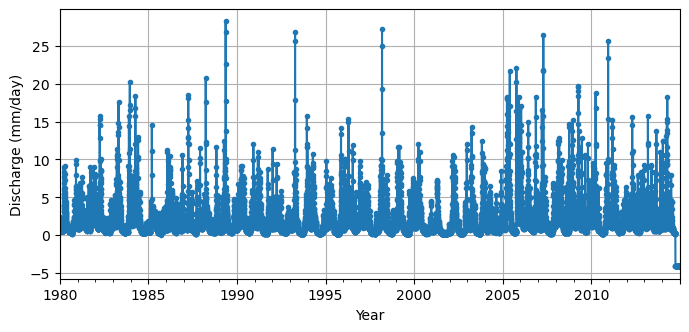

In [12]:
df["QObs(mm/d)"].plot(grid=True,marker=".",figsize = (8,3.5))
plt.ylabel("Discharge (mm/day)")
plt.xlabel("Year")
plt.show()

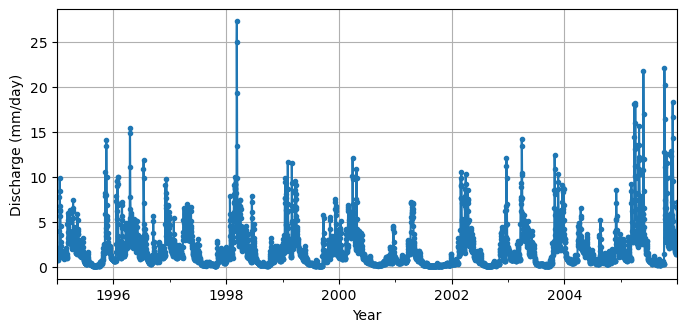

In [13]:
df["1995":"2005"]["QObs(mm/d)"].plot(grid=True,marker=".",figsize = (8,3.5))
plt.ylabel("Discharge (mm/day)")
plt.xlabel("Year")
plt.show()

## Preprocess data sets for machine learning

We want to predict the stream discharge rate for the future, given the past meteorological data sets. We will first preprocess the data using the `StandardScalar` from `sci-kit learn`.

In [14]:
targets = df[["QObs(mm/d)"]].copy()
features = df.drop(columns = ['Year', 'Mnth', 'Day', 'Hr', 'dayl(s)','swe(mm)','QObs(mm/d)']).copy()

array([[<Axes: title={'center': 'prcp(mm/day)'}>,
        <Axes: title={'center': 'srad(W/m2)'}>],
       [<Axes: title={'center': 'tmax(C)'}>,
        <Axes: title={'center': 'tmin(C)'}>],
       [<Axes: title={'center': 'vp(Pa)'}>, <Axes: >]], dtype=object)

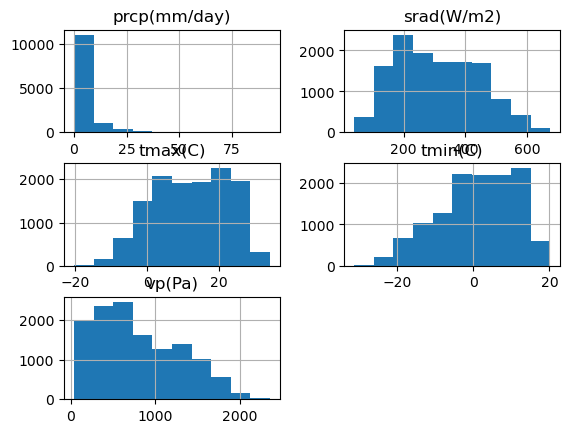

In [15]:
features.hist()

array([[<Axes: title={'center': 'QObs(mm/d)'}>]], dtype=object)

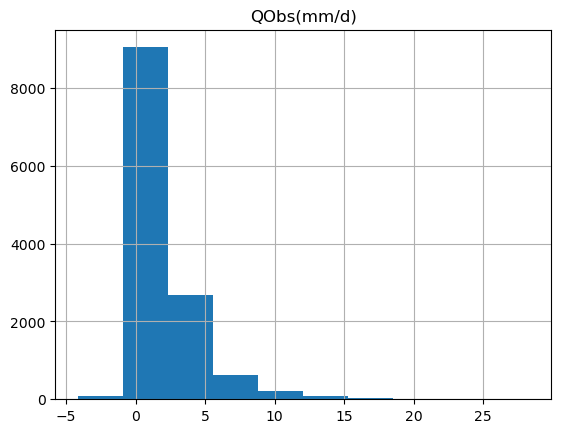

In [16]:
targets.hist()

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [18]:
target_scaler = StandardScaler()
feature_scaler = StandardScaler()

In [19]:
scaled_targets = target_scaler.fit_transform(targets)
scaled_features = feature_scaler.fit_transform(features)

(array([9.200e+01, 9.043e+03, 2.685e+03, 6.310e+02, 2.000e+02, 7.300e+01,
        3.700e+01, 1.100e+01, 5.000e+00, 7.000e+00]),
 array([-2.48310772, -1.19094774,  0.10121224,  1.39337221,  2.68553219,
         3.97769217,  5.26985214,  6.56201212,  7.85417209,  9.14633207,
        10.43849205]),
 <BarContainer object of 10 artists>)

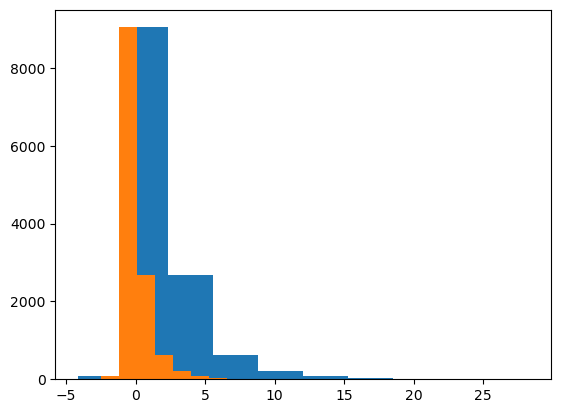

In [20]:
plt.hist(targets)
plt.hist(scaled_targets)

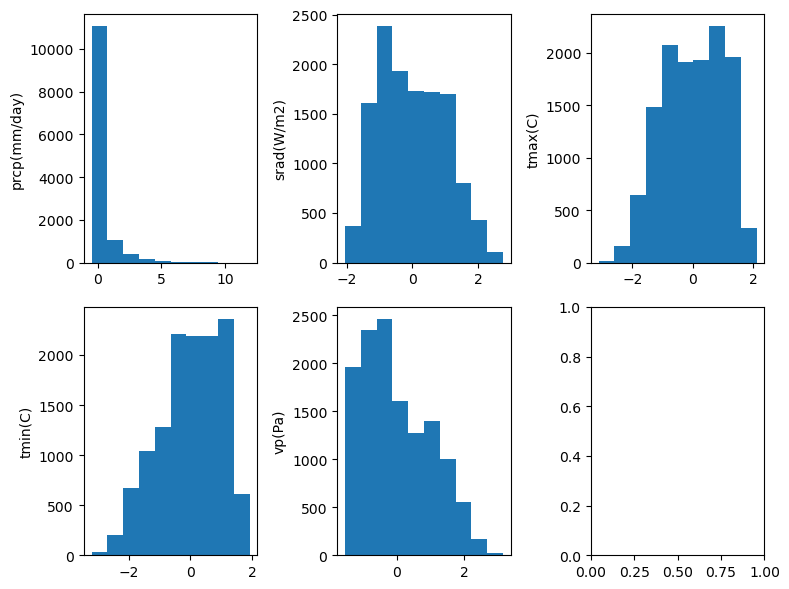

In [21]:
fig, axs = plt.subplots(2, 3,figsize=(8,6))

ax = axs.ravel()
for i in range(0,5):
    ax[i].hist(scaled_features[:,i])
    ax[i].set_ylabel(features.columns[i])
plt.tight_layout()

## Reshaping data for RNN training

We next need to reshape data so that it is in the correct format to train an RNN, LSTM, or GRU model. Recurrent neural networks expect sequential input of the shape `(sequence length, number of features)`. We want to train a model to predict a single day of discharge from `n` days of previous meteorological observations. For example, if `n = 365`, then a single training sample should be of the shape `(365, number of features)`. Here we use 5 input features, so the shape would be `(365, 5). 

However, the time series data is currently stored in a matrix, where the number of rows correspons to the total number of days in the training data set, and the number of columns is the number of features. We need to slide over this matrix and cut out small samples to act as training samples for the RNN models that we are going to train. `Keras` and `Tensorflow` have a couple of different utility functions that can help us with this task. 

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

2025-08-05 13:29:03.038433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-05 13:29:03.058712: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-05 13:29:03.065859: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-05 13:29:03.081860: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-05 13:29:06.076523: I tenso

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [23]:
my_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


2025-08-05 13:29:10.826134: W tensorflow/core/framework/dataset.cc:993] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2025-08-05 13:29:10.828915: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-05 13:29:10.834537: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-05 13:29:10.842828: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [25]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [26]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

## Split data into training, validation, and test data
In addition to setting up the sequence data sets for training the model, we need to designate part of our time series for training, part for validation, and part for testing. We will use 1980 - 1995 for training, 1995 - 2000 for validation, and 2000 to 2010 as our independent test data set. 

In [27]:
trainmask = (df.index >="1980-10-01") & (df.index <="1995-09-30")
valmask = (df.index >="1995-10-01") & (df.index <="2000-09-30")
testmask = (df.index >="2000-10-01") & (df.index <="2010-09-30")

In [28]:
trainidx = np.where(trainmask)[0]
validx = np.where(valmask)[0]
testidx = np.where(testmask)[0]

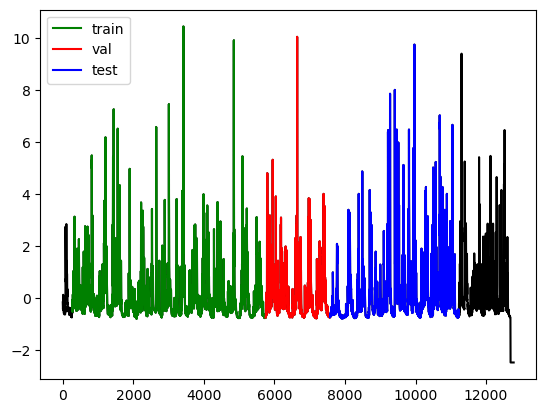

In [29]:
plt.plot(scaled_targets,color="k")
plt.plot(trainidx,scaled_targets[trainidx],color="g",label="train")
plt.plot(validx,scaled_targets[validx],color="r",label="val")
plt.plot(testidx,scaled_targets[testidx],color="b",label="test")
plt.legend()

We will use an entire year of meteorological data as input to predict the next time step.

In [31]:
sequence_length = 365 # Length of the meteorological record provided to the network

In [32]:
tf.random.set_seed(42)  # ensures reproducibility

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    scaled_features[trainidx],
    targets=scaled_targets[trainidx][sequence_length - 1:],
    sequence_length=sequence_length,
    batch_size=256,
    shuffle=True,
    seed=42
)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    scaled_features[validx],
    targets=scaled_targets[validx][sequence_length - 1:],
    sequence_length=sequence_length,
    batch_size=2048
)
test_ds = tf.keras.utils.timeseries_dataset_from_array(
    scaled_features[testidx],
    targets=scaled_targets[testidx][sequence_length - 1:],
    sequence_length=sequence_length,
    batch_size=len(testidx)
)

In [33]:
for x, y in train_ds.take(1):
    print("Input shape:", x.shape) 
    print("Target shape:", y.shape) 

Input shape: (256, 365, 5)
Target shape: (256, 1)


## Train a Simple RNN
We'll first try training an RNN model. 

In [34]:
import os

cwd = os.getcwd()

model_path = os.path.join(cwd,'saved_model')

In [36]:
# set some hyperparameters
n_hidden = 10
patience = 20
epochs = 100
learning_rate = 1e-3

This code creates the RNN model using `tf.keras.Sequential`.

In [37]:
tf.random.set_seed(42)  # ensures reproducibility
rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(n_hidden, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

In [38]:
rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 10)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171 (684.00 B)

 Trainable params: 171 (684.00 B)

 Non-trainable params: 0 (0.00 B)

We'll include a custom metric, the Nash Sutcliffe Efficiency, which is a widely used metric in hydrology for assessing how well a model predicts the observed data.

In [39]:
class NashSutcliffeEfficiency(tf.keras.metrics.Metric):
    def __init__(self, name='nse', scaler=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.sse = self.add_weight(name='sse', initializer='zeros')
        self.sst = self.add_weight(name='sst', initializer='zeros')
        self.scaler = scaler

    def update_state(self, y_true, y_pred, sample_weight=None):
        if self.scaler is not None:
            u = self.scaler.mean_
            s = self.scaler.var_
            y_true = y_true*s+u
            y_pred = y_pred*s+u

        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        sse = tf.reduce_sum(tf.square(y_true - y_pred))
        sst = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
        self.sse.assign_add(sse)
        self.sst.assign_add(sst)

    def result(self):
        return 1.0 - self.sse / self.sst

    def reset_states(self):
        self.sse.assign(0.0)
        self.sst.assign(0.0)

In [40]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=patience, restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [41]:
rnn_model.compile(loss='mse', optimizer=opt, metrics=[NashSutcliffeEfficiency(scaler=target_scaler)])
history = rnn_model.fit(train_ds, validation_data=valid_ds, epochs=epochs,callbacks=[early_stopping_cb])
rnn_model.save(os.path.join(model_path,'RNN_timeseries_model.keras'))

Epoch 1/100


2025-08-05 13:30:46.171011: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-05 13:30:46.283001: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 91001


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 1.1340 - nse: -0.3406 - val_loss: 0.9037 - val_nse: -0.0985
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.9300 - nse: -0.0687 - val_loss: 0.7581 - val_nse: 0.0785
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.8025 - nse: 0.0706 - val_loss: 0.6561 - val_nse: 0.2025
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.6915 - nse: 0.2046 - val_loss: 0.5800 - val_nse: 0.2950
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.5788 - nse: 0.2940 - val_loss: 0.5227 - val_nse: 0.3646
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.5102 - nse: 0.3470 - val_loss: 0.4942 - val_nse: 0.3993
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.5330 - nse: 0.3967 - val_loss: 0.4681 - val_nse: 0.4310
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.4456 - nse: 0.4488 - val_loss: 0.4472 - val_nse: 0.4564
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.42

In [42]:
valid_loss, valid_mae = rnn_model.evaluate(valid_ds)
valid_mae

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.2509 - nse: 0.6950


0.6949852705001831

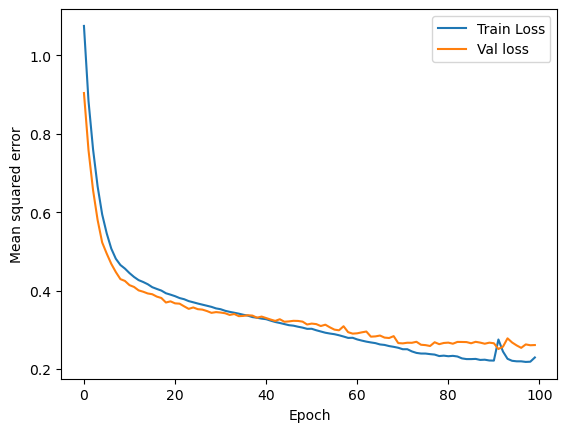

In [43]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.plot(history.epoch, np.array(history.history['loss']),label='Train Loss')
plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Val loss')
plt.legend()

In [44]:
out = rnn_model.predict(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


In [45]:
out.shape

(3288, 1)

In [46]:
for x, y in test_ds.take(1):
    yvals = y.numpy()

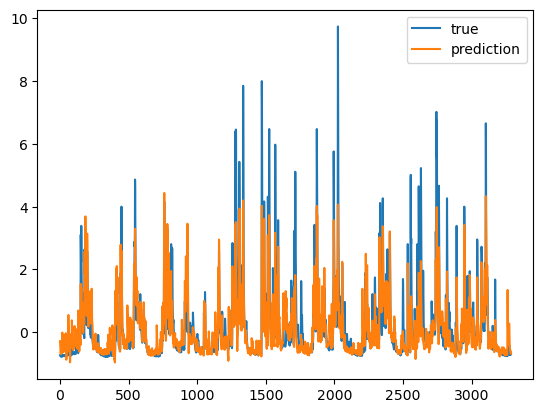

In [47]:
plt.plot(yvals,label="true")
plt.plot(out[:,0],label="prediction")
plt.legend()

## Train an LSTM model

In [48]:
from tensorflow.keras.initializers import Orthogonal

dropout_rate = 0.0
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(n_hidden, input_shape=[None, 5], return_sequences=False),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1)
])

In [49]:
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651 (2.54 KB)

 Trainable params: 651 (2.54 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=patience, restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [51]:
lstm_model.compile(loss='mse', optimizer=opt, metrics=[NashSutcliffeEfficiency(scaler=target_scaler)])
history_lstm = lstm_model.fit(train_ds, validation_data=valid_ds, epochs=epochs,callbacks=[early_stopping_cb])
lstm_model.save(os.path.join(model_path,'LSTM_timeseries_model.keras'))

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 1.0360 - nse: -0.2738 - val_loss: 0.8328 - val_nse: -0.0124
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.8614 - nse: 0.0108 - val_loss: 0.6761 - val_nse: 0.1781
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6929 - nse: 0.1742 - val_loss: 0.5764 - val_nse: 0.2993
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.5599 - nse: 0.2813 - val_loss: 0.4968 - val_nse: 0.3962
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.5378 - nse: 0.3731 - val_loss: 0.4296 - val_nse: 0.4778
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.4391 - nse: 0.4639 - val_loss: 0.3952 - val_nse: 0.5196
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.4061 - nse: 0.5293 - val_loss: 0.3599 - val_nse: 0.5625
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.3466 - nse: 0.5747 - val_loss: 0.3341 - val_nse: 0.5938
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - 

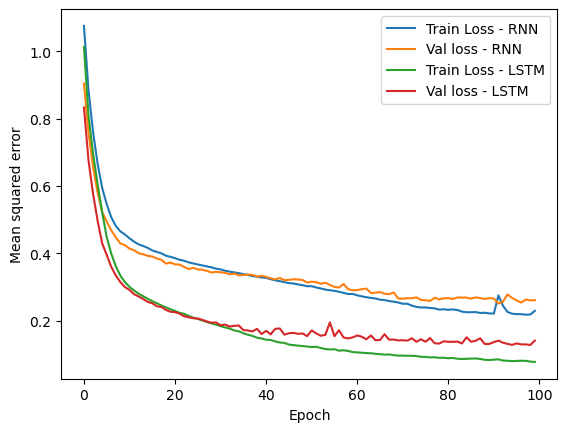

In [52]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.plot(history.epoch, np.array(history.history['loss']),label='Train Loss - RNN')
plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Val loss - RNN')
plt.plot(history_lstm.epoch, np.array(history_lstm.history['loss']),label='Train Loss - LSTM')
plt.plot(history_lstm.epoch, np.array(history_lstm.history['val_loss']),label = 'Val loss - LSTM')
plt.legend()

In [53]:
out_lstm = lstm_model.predict(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


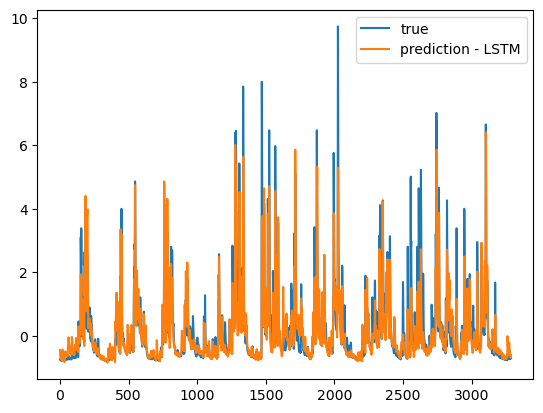

In [54]:
plt.plot(yvals,label="true")
plt.plot(out_lstm[:,0],label="prediction - LSTM")
plt.legend()

## Train a GRU model

In [55]:
tf.random.set_seed(42)  # ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(n_hidden, return_sequences=False, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

In [56]:
gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 521 (2.04 KB)

 Trainable params: 521 (2.04 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=patience, restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [58]:
gru_model.compile(loss='mse', optimizer=opt, metrics=[NashSutcliffeEfficiency(scaler=target_scaler)])
history_gru = gru_model.fit(train_ds, validation_data=valid_ds, epochs=epochs,callbacks=[early_stopping_cb])
gru_model.save(os.path.join(model_path,'GRU_timeseries_model.keras'))

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.8992 - nse: -0.0068 - val_loss: 0.6888 - val_nse: 0.1628
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6522 - nse: 0.1597 - val_loss: 0.5882 - val_nse: 0.2850
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.6388 - nse: 0.2456 - val_loss: 0.5335 - val_nse: 0.3515
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.5446 - nse: 0.3279 - val_loss: 0.4881 - val_nse: 0.4066
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.5215 - nse: 0.3803 - val_loss: 0.4516 - val_nse: 0.4510
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.5043 - nse: 0.4261 - val_loss: 0.4241 - val_nse: 0.4845
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4854 - nse: 0.4729 - val_loss: 0.4001 - val_nse: 0.5137
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4374 - nse: 0.4975 - val_loss: 0.3762 - val_nse: 0.5427
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - l

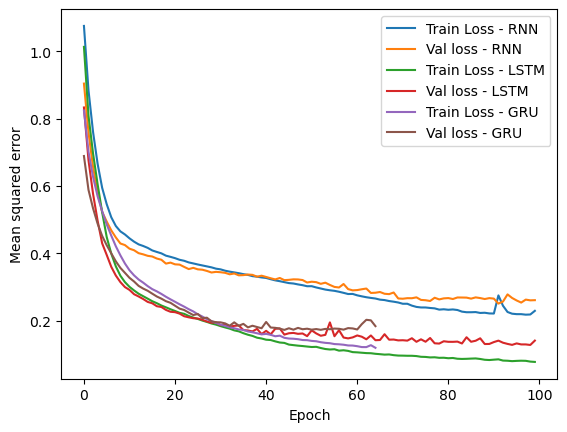

In [59]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.plot(history.epoch, np.array(history.history['loss']),label='Train Loss - RNN')
plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Val loss - RNN')
plt.plot(history_lstm.epoch, np.array(history_lstm.history['loss']),label='Train Loss - LSTM')
plt.plot(history_lstm.epoch, np.array(history_lstm.history['val_loss']),label = 'Val loss - LSTM')
plt.plot(history_gru.epoch, np.array(history_gru.history['loss']),label='Train Loss - GRU')
plt.plot(history_gru.epoch, np.array(history_gru.history['val_loss']),label = 'Val loss - GRU')
plt.legend()

In [60]:
out_gru = gru_model.predict(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


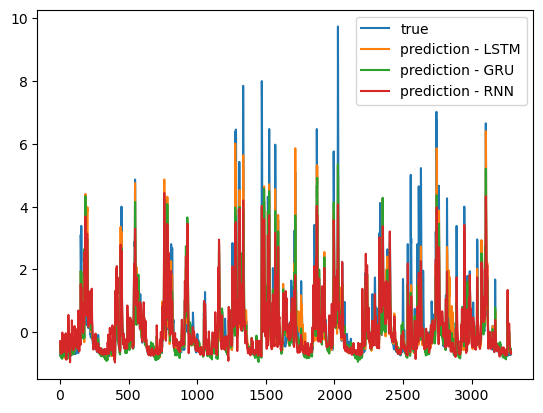

In [62]:
plt.plot(yvals,label="true")

plt.plot(out_lstm[:,0],label="prediction - LSTM")
plt.plot(out_gru[:,0],label="prediction - GRU")
plt.plot(out[:,0],label="prediction - RNN")
plt.legend()